In [18]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from sklearn.decomposition import PCA

In [19]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 2

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [20]:
print(mat_files[idx])

20s_long_heating_refl_50Hz_15J_Tamb_2.npy


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


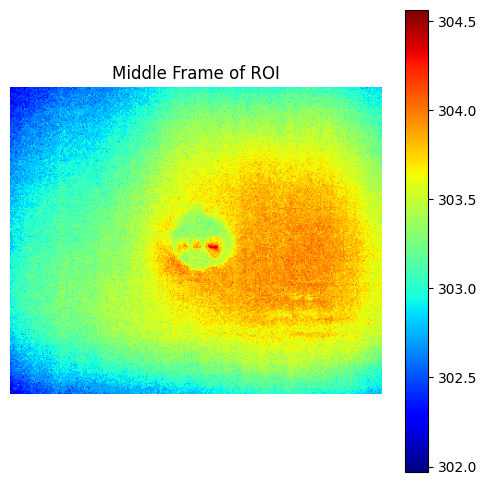

In [21]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

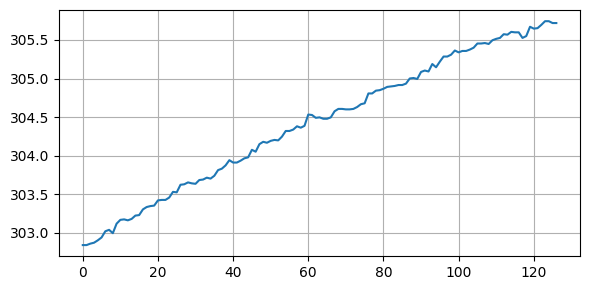

91


In [22]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 80

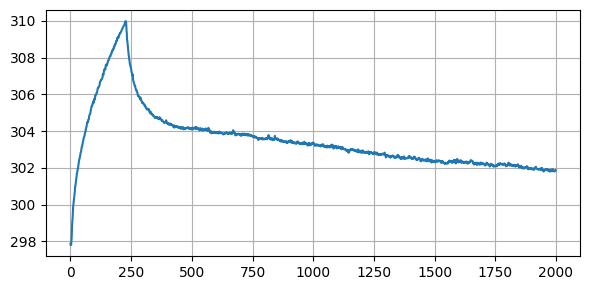

In [23]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

latent_dim = n_components

In [24]:
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x
    
class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()
        
        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')        
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=4, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')
        
        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)
        
        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)
        
        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)  
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )
        

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)
        
        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [27]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 3.6311 | Recon = 3.5534 | Z = 0.0777
Epoch 10: Total Loss = 0.0269 | Recon = 0.0137 | Z = 0.0132
Epoch 20: Total Loss = 0.0106 | Recon = 0.0064 | Z = 0.0042
Epoch 30: Total Loss = 0.0095 | Recon = 0.0068 | Z = 0.0026
Epoch 40: Total Loss = 0.0051 | Recon = 0.0035 | Z = 0.0016
Epoch 50: Total Loss = 0.0071 | Recon = 0.0054 | Z = 0.0016
Epoch 60: Total Loss = 0.0039 | Recon = 0.0028 | Z = 0.0011
Epoch 70: Total Loss = 0.0042 | Recon = 0.0034 | Z = 0.0008
Epoch 80: Total Loss = 0.0041 | Recon = 0.0034 | Z = 0.0007
Epoch 90: Total Loss = 0.0040 | Recon = 0.0033 | Z = 0.0007
Epoch 100: Total Loss = 0.0036 | Recon = 0.0030 | Z = 0.0005


In [28]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())
        
principal_comp = torch.cat(all_latents, dim=0).numpy()

In [29]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

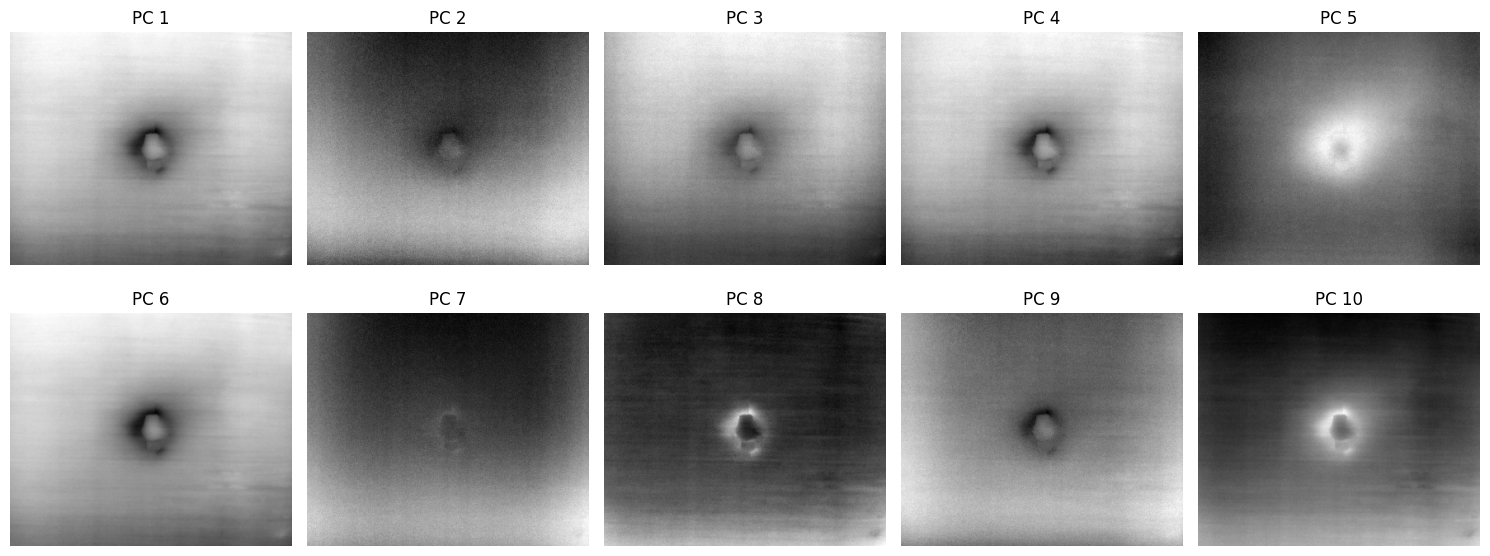

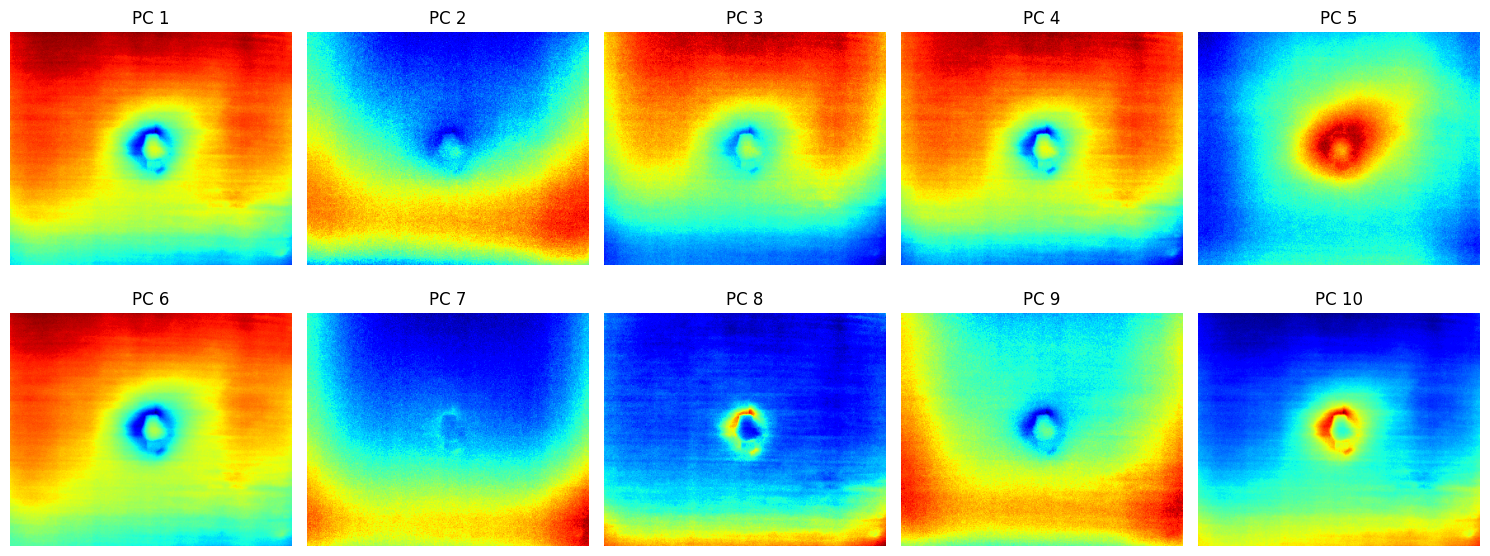

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

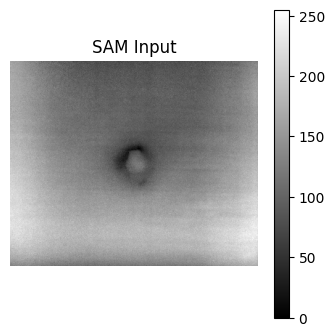

In [31]:
import torch
import cv2
import numpy as np
import os

comp = np.max(pca_array, axis=0)

comp -= comp.min()
comp /= (comp.max() + 1e-8)
comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, cmap='gray')
plt.title(f'SAM Input')
plt.axis('off')
plt.colorbar()
plt.show()


In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch

torch.manual_seed(1234)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat", device_map="auto", trust_remote_code=True, fp16=True).eval()

if hasattr(model, "generation_config"):
    model.generation_config.use_cache = False
    model.generation_config.do_sample = False
    model.generation_config.temperature = 0.0
    model.generation_config.top_p = 1.0
    model.generation_config.max_new_tokens = 512

Loading checkpoint shards: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


In [33]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [34]:
import os, re

system = (
    "You are an expert inspection assistant. "
    "Task: Detect the defects and describe their location. "
    "Follow these rules strictly: "
    "1) Output format must be exactly <ref>defect</ref><box>(x1,y1),(x2,y2)</box>. "
    "2) Use integer pixel coordinates for the thermal image; (x1,y1) is top-left, (x2,y2) is bottom-right, and x2>x1, y2>y1. "
    "3) If uncertain, output exactly <ref>none</ref><box>(0,0),(0,0)</box>. "
    "4) No extra text, no explanations. "
)

q1 = tokenizer.from_list_format([
    {"image": save_path},
    {"text": "Detect the defects and describe their location. Return only the requested format."}
])
_, history = model.chat(tokenizer, query=q1, history=None, system=system, use_cache=False)

ask = 'Return the defect locations only as <ref>defect</ref><box>(x1,y1),(x2,y2)</box>.'
resp, history = model.chat(tokenizer, ask, history=history, system=system, use_cache=False)

m = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp)
if not m:
    resp, history = model.chat(tokenizer, "The format was invalid. Repeat the box exactly in the required format.", history=history, system=system, use_cache=False)
    m = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp)

verify = "Verify the boxes are tight and correct. If correct, repeat identically; otherwise return corrected boxes in the exact same format."
resp2, history = model.chat(tokenizer, verify, history=history, system=system, use_cache=False)
m2 = re.search(r"<ref>(.*?)</ref>\s*<box>\((\d+),\s*(\d+)\),\((\d+),\s*(\d+)\)</box>", resp2)
final_resp = resp2 if m2 else resp

image = tokenizer.draw_bbox_on_latest_picture(final_resp, history)
if image:
    image.save("defect_box.jpg")
else:
    print("no box")
print(final_resp)

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


<ref> defect</ref><box>(398,383),(588,613)</box>
